# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Integración-de-datos" data-toc-modified-id="Integración-de-datos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Integración de datos</a></div><div class="lev1 toc-item"><a href="#Definición-de-funciones" data-toc-modified-id="Definición-de-funciones-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Definición de funciones</a></div><div class="lev2 toc-item"><a href="#get_species_data" data-toc-modified-id="get_species_data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>get_species_data</a></div><div class="lev2 toc-item"><a href="#get_sdm" data-toc-modified-id="get_sdm-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>get_sdm</a></div><div class="lev2 toc-item"><a href="#evaluate_sdms" data-toc-modified-id="evaluate_sdms-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>evaluate_sdms</a></div><div class="lev2 toc-item"><a href="#get_grid_iucn_intersection" data-toc-modified-id="get_grid_iucn_intersection-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>get_grid_iucn_intersection</a></div><div class="lev2 toc-item"><a href="#print_eval_stats" data-toc-modified-id="print_eval_stats-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>print_eval_stats</a></div><div class="lev2 toc-item"><a href="#plot_confussion_maps" data-toc-modified-id="plot_confussion_maps-26"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>plot_confussion_maps</a></div><div class="lev2 toc-item"><a href="#get_stats_per_species" data-toc-modified-id="get_stats_per_species-27"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>get_stats_per_species</a></div><div class="lev2 toc-item"><a href="#full_analysis" data-toc-modified-id="full_analysis-28"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>full_analysis</a></div><div class="lev1 toc-item"><a href="#Análisis-con-todas-las-especies-(439)-a-64,-32-y-16-km" data-toc-modified-id="Análisis-con-todas-las-especies-(439)-a-64,-32-y-16-km-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Análisis con todas las especies (439) a 64, 32 y 16 km</a></div><div class="lev2 toc-item"><a href="#Modelo-con-variables-climáticas-(WorldClim-1.4),-registros-de-mamíferos-(clase-Mammalia)-y-plantas-con-flor-(clase-Magnoliopsida)" data-toc-modified-id="Modelo-con-variables-climáticas-(WorldClim-1.4),-registros-de-mamíferos-(clase-Mammalia)-y-plantas-con-flor-(clase-Magnoliopsida)-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Modelo con variables climáticas (WorldClim 1.4), registros de mamíferos (clase Mammalia) y plantas con flor (clase Magnoliopsida)</a></div><div class="lev2 toc-item"><a href="#Modelo-con-variables-climáticas-(WorldClim-1.4)" data-toc-modified-id="Modelo-con-variables-climáticas-(WorldClim-1.4)-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modelo con variables climáticas (WorldClim 1.4)</a></div><div class="lev3 toc-item"><a href="#64-km" data-toc-modified-id="64-km-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>64 km</a></div><div class="lev3 toc-item"><a href="#32-Km" data-toc-modified-id="32-Km-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>32 Km</a></div><div class="lev3 toc-item"><a href="#16-km" data-toc-modified-id="16-km-323"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>16 km</a></div>

In [2]:
# Magics
%matplotlib inline

In [82]:
# Load libraries
from __future__ import print_function
from __future__ import division

# Web
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json

# Stats
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix


# GIS libs
import folium
import folium.plugins
import fiona # for reading and writing shapefiles
import geopandas as gpd

import os
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set()

def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    """
    Source: https://www.peterbe.com/plog/best-practice-with-retries-with-requests
    """
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session


# Integración de datos

La primer tarea es extraer la información en el shape de IUCN y crear malla de presencia y ausencia para comparar los resultados de un modelo climático de SPECIES. Utilizaremos una resolución de 64km por lado de celda.

In [14]:
# cargamos el mapa de IUCN
iucn_shp = gpd.read_file('data/IUCN/TERRESTRIAL_MAMMALS/TERRESTRIAL_MAMMALS.shp')

In [15]:
iucn_shp.head()

,id_no,binomial,presence,origin,seasonal,compiler,year,citation,source,dist_comm,...,order_,family,genus,code,marine,terrestial,freshwater,Shape_Leng,Shape_Area,geometry
0,17175,Phyllonycteris poeyi,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,CHIROPTERA,PHYLLOSTOMIDAE,Phyllonycteris,LC,f,t,f,42.448583,9.302263,(POLYGON ((-84.41569999999996 22.1800355930000...
1,17175,Phyllonycteris poeyi,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,CHIROPTERA,PHYLLOSTOMIDAE,Phyllonycteris,LC,f,t,f,25.228298,6.356187,POLYGON ((-72.80069999999995 19.95113559300006...
2,17224,Phyllotis darwini,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,RODENTIA,CRICETIDAE,Phyllotis,LC,f,t,f,33.818170,12.434855,POLYGON ((-70.44139999999999 -23.7277644069999...
3,15783,Oxymycterus angularis,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,RODENTIA,CRICETIDAE,Oxymycterus,LC,f,t,f,34.727689,37.371101,POLYGON ((-43.45839999999998 -2.59556440699992...
4,15793,Oxymycterus hiska,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,,,...,RODENTIA,CRICETIDAE,Oxymycterus,LC,f,t,f,14.310056,2.899256,POLYGON ((-66.71369999999996 -16.1478644079999...


In [3]:
# cargamos la malla de Mexico
analysis_res = 64
grid_path = os.path.join("grids/", "mx_grid_{}km.json".format(analysis_res))
grid = gpd.read_file(grid_path)

In [4]:
grid.head()

,gridid,geometry
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...
1,43508,"POLYGON ((-116.1341999309717 30.1278936836953,..."
2,43913,"POLYGON ((-115.5592781491352 30.1278936836953,..."
3,44317,POLYGON ((-114.9843563672987 29.62939167656038...
4,41885,POLYGON ((-118.4338870583177 28.62497658989397...


In [7]:
len(iucn_shp)

12546

In [ ]:
ax = grid.plot(color='blue')
iucn_shp.plot(ax=ax)

Una vez cargado el shape de IUCN necesitamos iterar sobre cada especie. Para cada especie obtenemos las celdas que ocupa y deberíamos agregar esas precencias a una mega PAM. La PAM tendrá un renglón por especie y una columna por celda (especies x celdas). Esta es una matriz dispersa (checar opciones para manejar este tipo de matrices p.ej en scypy). Los indices de la PAM los deberíamos mapear a nombres de especie y ids de celda

Nota: En MacOSX tuve que instalar rtree y spatialindex para que funcionara gpd.sjoin:
* pip install rtree
* brew install spatialindex

También hubo que reinstalar fiona y shapely desde código fuente porque aparecía el error: 
    
    Assertion failed: (0), function query, file AbstractSTRtree.cpp, line 285.
* pip install --no-binary :all: fiona
* pip install --no-binary :all: shapely

In [9]:
%time presence_cells = gpd.sjoin(grid, iucn_shp, op='intersects', how='left')

CPU times: user 1min 4s, sys: 478 ms, total: 1min 4s
Wall time: 1min 4s


In [35]:
presence_cells.head()

,gridid,geometry,index_right,id_no,binomial,presence,origin,seasonal,compiler,year,...,class,order_,family,genus,code,marine,terrestial,freshwater,Shape_Leng,Shape_Area
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,4231.0,41663.0,Taxidea taxus,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,CARNIVORA,MUSTELIDAE,Taxidea,LC,f,t,f,309.142318,971.013786
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,329.0,3745.0,Canis latrans,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,CARNIVORA,CANIDAE,Canis,LC,f,t,f,1075.987282,2143.776069
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,9302.0,14210.0,Myotis volans,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,CHIROPTERA,VESPERTILIONIDAE,Myotis,LC,f,t,f,346.334548,519.782825
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,8599.0,16672.0,Peromyscus maniculatus,1.0,1.0,1.0,IUCN,2009.0,...,MAMMALIA,RODENTIA,CRICETIDAE,Peromyscus,LC,f,t,f,811.214142,1524.249427
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,9138.0,42393.0,Odocoileus hemionus,1.0,1.0,1.0,IUCN,2009.0,...,MAMMALIA,CETARTIODACTYLA,CERVIDAE,Odocoileus,LC,f,t,f,392.101065,729.819443


Agrupamos por especie el DF de presencias

In [13]:
sp_cells = presence_cells.groupby(by='binomial')

In [14]:
iucn_data = sp_cells.get_group('Ammospermophilus interpres')
iucn_data.head()

,gridid,geometry,index_right,id_no,binomial,presence,origin,seasonal,compiler,year,...,class,order_,family,genus,code,marine,terrestial,freshwater,Shape_Leng,Shape_Area
21,54034,POLYGON ((-101.1862336032229 28.11911671800926...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
24,54031,POLYGON ((-101.1862336032229 26.58726561098146...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
25,54033,POLYGON ((-101.1862336032229 27.61085890614313...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
161,54035,POLYGON ((-101.1862336032229 28.62497658989397...,6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569
183,54030,"POLYGON ((-101.1862336032229 26.0719904140863,...",6186.0,42451.0,Ammospermophilus interpres,1.0,1.0,1.0,IUCN,2008.0,...,MAMMALIA,RODENTIA,SCIURIDAE,Ammospermophilus,LC,f,t,f,29.402466,29.085569


Para cada especie tenemos un mapa que tomamos como la verdad sobre la distribución de la especie

CPU times: user 37.2 ms, sys: 339 µs, total: 37.5 ms
Wall time: 37.5 ms


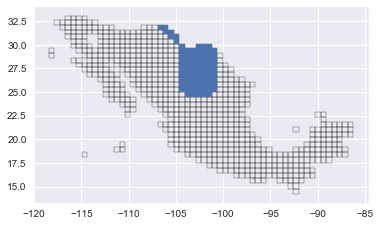

In [15]:
ax = grid.plot(facecolor='none', edgecolor='k')
iucn_data.plot(ax=ax)


In [17]:
url_api = 'http://species.conabio.gob.mx/api/niche/'
endpoint = 'getCellScore'
params = "id=27923&idtime=1525302357735&apriori=apriori&min_occ=5&fossil=false&mapa_prob=mapa_prob&sfecha=false&val_process=false&idtabla=no_table&grid_res=64&tfilters%5B0%5D%5Bvalue%5D=root_bioclim&tfilters%5B0%5D%5Btype%5D=0&tfilters%5B0%5D%5Blevel%5D=0&tfilters%5B0%5D%5Blabel%5D=Bioclim&tfilters%5B1%5D%5Bfield%5D=clasevalida&tfilters%5B1%5D%5Bvalue%5D=Mammalia&tfilters%5B1%5D%5Btype%5D=4&tfilters%5B2%5D%5Bfield%5D=clasevalida&tfilters%5B2%5D%5Bvalue%5D=Magnoliopsida&tfilters%5B2%5D%5Btype%5D=4&hasBios=true&hasRaster=true"

query = "{}{}?{}".format(url_api, endpoint, params)
r = requests.get(query)
data = json.loads(r.content)
data = data['data']
data = pd.DataFrame(data)

In [206]:
sdm_2 = get_sdm(api_url, 27923, analysis_res=64, bioclim_groups=bioclim_groups, biotic_groups=biotic_groups)

In [207]:
sdm_2.describe()

,gridid,tscore
count,1684.000000,1.684000e+03
mean,52599.232185,1.138958e-01
std,6181.927282,3.146579e-01
min,41863.000000,0.000000e+00
25%,47156.750000,0.000000e+00
50%,52409.500000,3.024173e-16
75%,57662.250000,4.750594e-03
max,64168.000000,1.000000e+00


In [19]:
sdm = grid.merge(data, on='gridid')
sdm.tscore = pd.to_numeric(sdm.tscore)
sdm.head()

,gridid,geometry,tscore
0,43507,POLYGON ((-116.1341999309717 29.62939167656038...,0.000000e+00
1,43508,"POLYGON ((-116.1341999309717 30.1278936836953,...",0.000000e+00
2,43913,"POLYGON ((-115.5592781491352 30.1278936836953,...",0.000000e+00
3,44317,POLYGON ((-114.9843563672987 29.62939167656038...,0.000000e+00
4,41885,POLYGON ((-118.4338870583177 28.62497658989397...,3.256122e-169


In [20]:
sdm_eval = sdm.merge(iucn_data[['gridid', 'presence']], on='gridid', how='left')
sdm_eval['presence'] = sdm_eval['presence'].fillna(0).astype(int)
sdm_eval['pred'] = sdm_eval['tscore'].round(0).astype(int)

sdm_eval['confussion'] = 2*sdm_eval['presence'] + sdm_eval['pred']
labels = {
    0: 'True negative',
    1: 'False possitive',
    2: 'False negative',
    3: 'True possitive'
}
sdm_eval['confussion_labels'] = [labels[conf_val] for conf_val in sdm_eval['confussion']]

In [21]:
sdm_eval[sdm_eval['confussion'] == 3].head()

,gridid,geometry,tscore,presence,pred,confussion,confussion_labels
24,54031,POLYGON ((-101.1862336032229 26.58726561098146...,1.0,1,1,3,True possitive
183,54030,"POLYGON ((-101.1862336032229 26.0719904140863,...",1.0,1,1,3,True possitive
184,54032,POLYGON ((-101.1862336032229 27.10023197012804...,1.0,1,1,3,True possitive
187,54029,POLYGON ((-101.1862336032229 25.55443784768825...,1.0,1,1,3,True possitive
205,54036,"POLYGON ((-101.1862336032229 29.1284105912999,...",1.0,1,1,3,True possitive


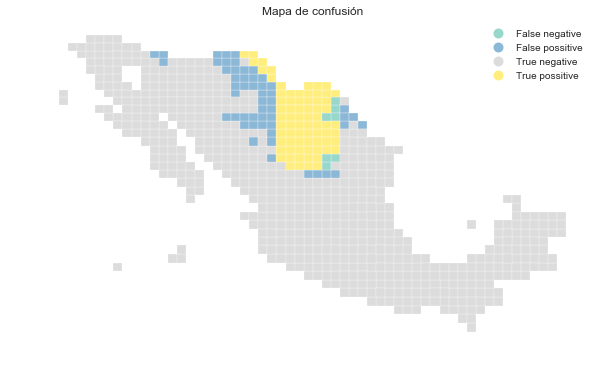

In [22]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title(u'Mapa de confusión')
sdm_eval.plot(ax=ax,
              column='confussion_labels',
              cmap='Set3',
              alpha=0.9,
              edgecolor='w',
              legend=True,
              categorical=True)
ax.set_axis_off()

In [23]:
print('Accuracy: ', accuracy_score(sdm_eval.presence, sdm_eval.pred))
print('F1 score: ', f1_score(sdm_eval.presence, sdm_eval.pred))
print('Recall: ', recall_score(sdm_eval.presence, sdm_eval.pred))
print('Precision: ', precision_score(sdm_eval.presence, sdm_eval.pred))
print('\n clasification report: \n', classification_report(sdm_eval.presence, sdm_eval.pred))
print('\n confussion matrix: \n',confusion_matrix(sdm_eval.presence, sdm_eval.pred))


Accuracy:  0.9198369565217391
F1 score:  0.7093596059113302
Recall:  0.9113924050632911
Precision:  0.5806451612903226

 clasification report: 
              precision    recall  f1-score   support

          0       0.99      0.92      0.95       657
          1       0.58      0.91      0.71        79

avg / total       0.94      0.92      0.93       736


 confussion matrix: 
 [[605  52]
 [  7  72]]


# Definición de funciones

In [4]:
api_url = 'http://species.conabio.gob.mx/api/niche'

## get_species_data

In [5]:
def get_species_data(api_url, name, analysis_res=16):
    """ Regresa un dataframe con la información taxonomica de una especie y su id en la base de datos  """
    query = {
        "searchStr":name, # Nombre de la especie substring de la especie a buscar
        "source":1,        
        "limit": "true",
        "grid_res": 16
    }
    r = requests.post(api_url+'/especie/getEntList', params=query)

    response = json.loads(r.content)
    return pd.DataFrame(response['data'])

## get_sdm
Obtener un modelo de distribución utilizando el API de SPECIES

In [222]:
def get_sdm(api_url, sp_id, analysis_res=32, bioclim_groups={}, biotic_groups={}, verbose=False):
    endpoint = 'getCellScore'
    has_raster = 'false'
    has_bios = 'false'
    
    params = {
        "id": "{}".format(sp_id),
        "lim_inf": "1940",
        "lim_sup": "2020",
        "idtime": "1525302357735",
        "apriori": "apriori",
        "min_occ": "5",
        "fossil": "false",
        "mapa_prob": "mapa_prob",
        "sfecha": "false",
        "val_process": "false",
        "idtabla": "no_table",
        "grid_res": "{}".format(analysis_res),
    }
    
    if bioclim_groups:
        has_raster = 'true'
        for i, k in enumerate(bioclim_groups.keys()):
            value = bioclim_groups[k]
            abio_type = str(0)
            abio_level = str(0)
            abio_label = k
            params.update({
              "tfilters[{}][value]".format(i): value,
              "tfilters[{}][type]".format(i): abio_type,
              "tfilters[{}][level]".format(i): abio_level,
              "tfilters[{}][label]".format(i): abio_label,  
            })
    if biotic_groups:
        offset = len(bioclim_groups)
        has_bios = 'true'

        for i, k in enumerate(biotic_groups.keys()):
            index = i + offset
            field = biotic_groups[k]
            value = k 
            bio_type = str(4)
            params.update({
                "tfilters[{}][field]".format(index): field,
                "tfilters[{}][value]".format(index): value,
                "tfilters[{}][type]".format(index): bio_type
            })
    params.update({
        "hasBios": has_bios,
        "hasRaster": has_raster
    })
    
    query = api_url + "/{}".format(endpoint)
    r = requests_retry_session(retries=10).post(query, params, timeout=200)
        
    data = json.loads(r.content)
    data = data['data']

    data = pd.DataFrame(data)
    if data.empty:
        print('No data')
    else:
        data.tscore = pd.to_numeric(data.tscore)    
    
    return data


## evaluate_sdms

Esta función obtiene modelos de distribución para las especies $e_i$, donde $i$ es tal que $start \leq i \lt end$, y etiqueta cada resultado como 'True possitive', 'True negative', 'False possitive', ó, 'False negative' de acuerdo a los  modelos de distribución de referencia (**sp_cells**).

In [221]:
def evaluate_sdms(api_url, sp_cells, grid, analysis_res = 64, start = 0, end = 20, bioclim_groups = {}, biotic_groups = {}, verbose=False):
    try:
        sp_dfs = []
        labels = {
            0: 'True negative',
            1: 'False possitive',
            2: 'False negative',
            3: 'True possitive'
        }

        for sp in sp_cells.groups.keys()[start:end]:
            if verbose:
                print(sp)
            truth = sp_cells.get_group(sp)
            species_data = get_species_data(api_url, sp, analysis_res)

            if {'spid'}.issubset(species_data.columns):
                spid = species_data['spid'][0]
                sdm = get_sdm(api_url, spid, analysis_res=analysis_res, bioclim_groups=bioclim_groups, biotic_groups=biotic_groups, verbose=verbose)

                if not sdm.empty:
                    sdm = grid.merge(sdm, on='gridid')
                    sdm['species'] = sp

                    sdm_eval = sdm.merge(truth[['gridid', 'presence']], on='gridid', how='left')
                    if {'tscore'}.issubset(sdm_eval.columns):
                        sdm_eval['presence'] = sdm_eval['presence'].fillna(0).astype(int)            
                        sdm_eval['pred'] = sdm_eval['tscore'].round(0).astype(int)
                        sdm_eval.loc[sdm_eval.presence > 2, 'presence'] = 0
                        sdm_eval.loc[sdm_eval.presence == 2, 'presence'] = 1
                        sdm_eval['confussion'] = 2*sdm_eval['presence'] + sdm_eval['pred']
                        sdm_eval['confussion_labels'] = [labels[conf_val] for conf_val in sdm_eval['confussion']]
                        sp_dfs.append(sdm_eval)
                        if verbose:
                            print("Num. Especies: ", len(sp_dfs))
    except requests.exceptions.RequestException as err:
        print("Error de conexión: ", err)
        return pd.concat(sp_dfs)                
        
    return pd.concat(sp_dfs)

## get_grid_iucn_intersection

In [8]:
def get_grid_iucn_intersection(grid_dir, analysis_res, iucn_shp):
    grid_path = os.path.join(grid_dir, "mx_grid_{}km.json".format(analysis_res))
    grid = gpd.read_file(grid_path)
    
    presence_cells = gpd.sjoin(iucn_shp, grid, how='right', op='intersects')
    sp_cells = presence_cells.groupby(by='binomial')
    
    return sp_cells

## print_eval_stats
Para evaluar el desempeño reportamos la precisión, cobertura, exactitud y score F1. Las definiciones de estas estadísticas son:

Sean
* $tp$ los verdaderos positivos
* $tn$ los verdaderos negativos
* $fp$ los falsos positivos
* $fn$ los falsos negativos

entonces definimos la precisión, el recall, la exactitud (accuracy), y el score f1 de la siguiente manera:

$$
\begin{align}
precision &= \frac{tp}{tp + fp} \\
recall &= \frac{tp}{tp + fn} \\
accuracy &= \frac{tp + tn}{tp + fp + tn + fn} \\
f1 &= \frac{2}{\frac{1}{precision} + \frac{1}{recall}}
\end{align}
$$

In [177]:
def print_eval_stats(sdms_df):
    fig = print_confusion_matrix(confusion_matrix(sdms_df.presence, sdms_df.pred), class_names=[0, 1])
    plt.show(fig)
    print('Accuracy: ', accuracy_score(sdms_df.presence, sdms_df.pred))
    print('F1 score: ', f1_score(sdms_df.presence, sdms_df.pred))
    print('Recall: ', recall_score(sdms_df.presence, sdms_df.pred))
    print('Precision: ', precision_score(sdms_df.presence, sdms_df.pred))
    print('\n clasification report: \n', classification_report(sdms_df.presence, sdms_df.pred))
        
    stats = []
    sp_grp = sdms_df.groupby('species')
    for name, grp in sp_grp:
        acc = accuracy_score(grp.presence, grp.pred)
        f1 = f1_score(grp.presence, grp.pred)
        recall = recall_score(grp.presence, grp.pred)
        prec = precision_score(grp.presence, grp.pred)

        stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec, 'name': name})
    
    df_test = pd.melt(df[['f1', 'acc', 'recall', 'precision']], var_name=['estadistica'], value_name='valor')
    g = sns.FacetGrid(df_test, col='estadistica', size=4)
    g.map(sns.distplot, 'valor', bins=10, kde=True, rug=True)

## plot_confussion_maps

In [191]:
def plot_confussion_maps(sdms_df, num_plots, title=''):
    flatui = ['#ca0020','#f4a582','#92c5de','#0571b0']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())
    
    nrows = num_plots // 3
    f, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows*4))
    sp_grp = sdms_df.groupby('species')

    axes = axes.flat
    ax_num = 0

    for name, grp in sp_grp:
        if ax_num >= len(axes):
            break
        ax = axes[ax_num]
        ax_num += 1
        acc = accuracy_score(grp.presence, grp.pred)
        f1 = f1_score(grp.presence, grp.pred)
        recall = recall_score(grp.presence, grp.pred)
        prec = precision_score(grp.presence, grp.pred)
        ax.set_title('{}: acc={}, f1={}, r={}, p={}'.format(
            title, name, round(acc, 2), round(f1, 2), round(recall, 2), round(prec, 2)), loc="left")
        
        grp.plot(ax=ax,
                  column='confussion_labels',
                  alpha=0.9,
                  edgecolor='w',
                  legend=True,
                  categorical=True,
                  cmap=my_cmap)
        ax.set_axis_off()

    f.tight_layout()
    return f

In [189]:
def plot_bottom_mid_top_maps(smds_df, quant_size):
    stats = get_stats_per_species(smds_df)
    stats_df = pd.DataFrame(stats)
    
    low, mid_0, mid_1, top = stats_df.f1.quantile([quant_size, 0.5, 0.5 + quant_size, 1 - quant_size])
    
    low_f1_sp = stats_df[stats_df.f1 <= low]
    mid_f1_sp = stats_df[stats_df.f1.between(mid_0, mid_1)]
    top_f1_sp = stats_df[stats_df.f1 >= top]

    plot_confussion_maps(smds_df[smds_df.species.isin(low_f1_sp.name)], 6)
    plot_confussion_maps(smds_df[smds_df.species.isin(mid_f1_sp.name)], 6)
    plot_confussion_maps(smds_df[smds_df.species.isin(top_f1_sp.name)], 6)

## get_stats_per_species

In [11]:
def get_stats_per_species(sdms_df):
    stats = []
    sp_grp = sdms_df.groupby('species')
    for name, grp in sp_grp:
        acc = accuracy_score(grp.presence, grp.pred)
        f1 = f1_score(grp.presence, grp.pred)
        recall = recall_score(grp.presence, grp.pred)
        prec = precision_score(grp.presence, grp.pred)

        stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec, 'name': name})
    return stats

## full_analysis

In [234]:
def full_analysis(analysis_res, truth_shape, n=None, grid_dir='grids/', bioclim_groups={}, biotic_groups={}, verbose=False):
    flatui = ['#ca0020','#f4a582','#92c5de','#0571b0']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())
    
    grid_path = os.path.join(grid_dir, "mx_grid_{}km.json".format(analysis_res))
    grid = gpd.read_file(grid_path)

    # obtener grid con la resolucion que se necesita e intersecar grid con modelos de iucn
    sp_cells = get_grid_iucn_intersection(grid_dir, analysis_res, truth_shape)
    
    if not n:
        n = len(sp_cells)
        
    sdms_df = evaluate_sdms(api_url, sp_cells, grid,
                            analysis_res, start = 0, end=n,
                            bioclim_groups = bioclim_groups, 
                            biotic_groups = biotic_groups,
                            verbose = verbose)
    
    print_eval_stats(sdms_df)
    plot_confussion_maps(sdms_df, 20)
            
    return sdms_df

## print_confusion_matrix
Fuente: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

In [76]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [12]:
flatui = ['#ca0020','#f4a582','#92c5de','#0571b0']
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

# Análisis con todas las especies (439) a 64, 32 y 16 km

## Modelo con variables climáticas (WorldClim 1.4), registros de mamíferos (clase Mammalia) y plantas con flor (clase Magnoliopsida)

### 64 km

In [208]:
bioclim_groups = {'Bioclim': 'root_bioclim'}
biotic_groups = {'Mammalia': 'clasevalida', 'Magnoliopsida': 'clasevalida'}

In [ ]:
%time sdms64_df = full_analysis(analysis_res=64, truth_shape=iucn_shp, bioclim_groups=bioclim_groups, biotic_groups=biotic_groups)

Accuracy:  0.8466286887730171
F1 score:  0.6798491949748874
Recall:  0.9080953366445916
Precision:  0.5432943312903692

 clasification report: 
              precision    recall  f1-score   support

          0       0.98      0.83      0.90    265362
          1       0.54      0.91      0.68     57984

avg / total       0.90      0.85      0.86    323346


 confussion matrix: 
 [[221099  44263]
 [  5329  52655]]


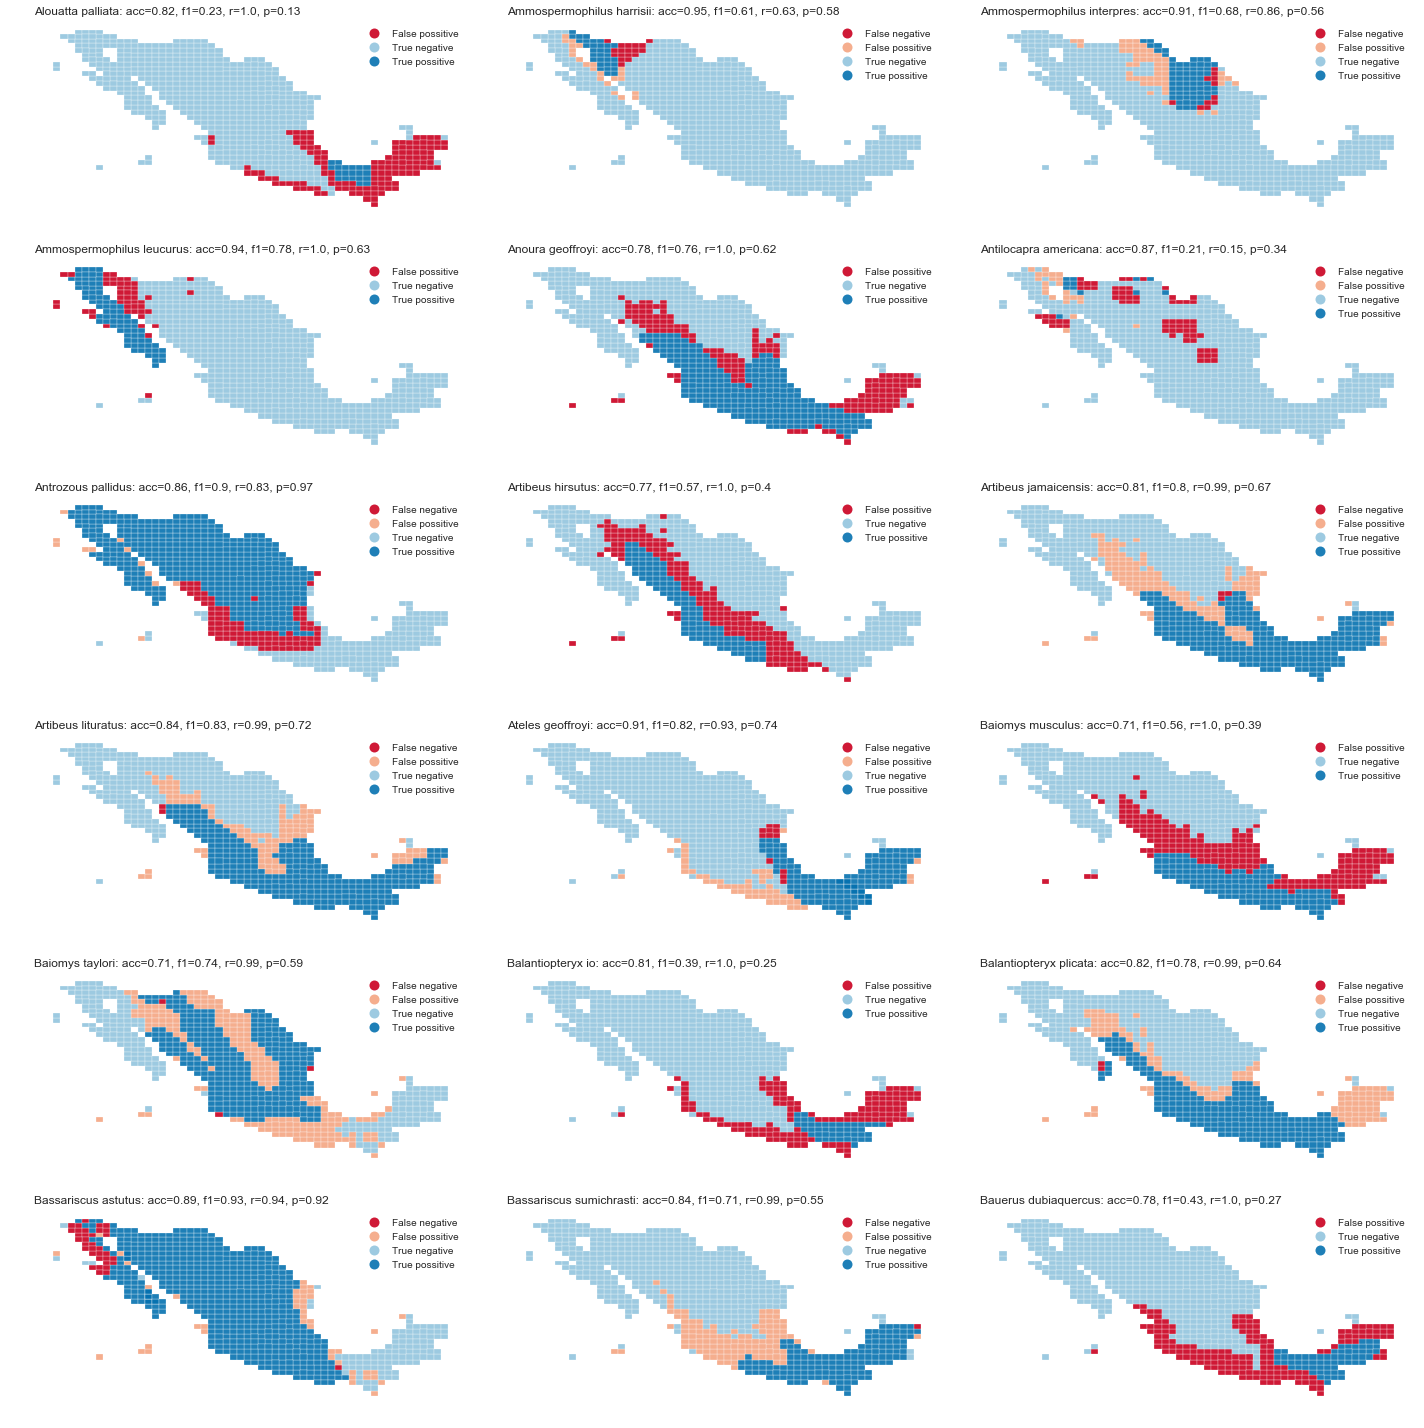

In [165]:
print_eval_stats(sdms64_df)
plot_confussion_maps(sdms64_df, 20)

In [188]:
stats = []
sp_grp = sdms_df.groupby('species')
for name, grp in sp_grp:
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    
    stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec, 'name': name})

/Users/RaulSierra/.virtualenvs/curso-espacial/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/RaulSierra/.virtualenvs/curso-espacial/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [211]:
df = pd.DataFrame(stats)
df.describe()

,acc,f1,precision,recall
count,439.000000,439.000000,439.000000,439.000000
mean,0.846705,0.527699,0.448142,0.881256
std,0.113516,0.266569,0.280770,0.201736
min,0.259358,0.000000,0.000000,0.000000
25%,0.786685,0.294118,0.188194,0.858951
50%,0.865489,0.568995,0.457143,0.973856
75%,0.930123,0.743026,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000


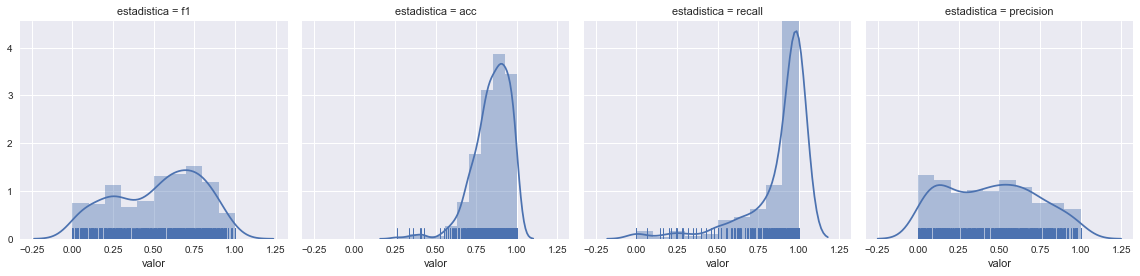

In [214]:
df_test = pd.melt(df[['f1', 'acc', 'recall', 'precision']], var_name=['estadistica'], value_name='valor')

g = sns.FacetGrid(df_test, col='estadistica', size=4)
g.map(sns.distplot, 'valor', bins=10, kde=True, rug=True)

### 32 km

In [ ]:
%time sdms32_df = full_analysis(analysis_res=64, truth_shape=iucn_shp, bioclim_groups=bioclim_groups, biotic_groups=biotic_groups)

Accuracy:  0.8660252158324088
F1 score:  0.6878601536118119
Recall:  0.8645869738088364
Precision:  0.5711198027321728

 clasification report: 
              precision    recall  f1-score   support

          0       0.97      0.87      0.91    958904
          1       0.57      0.86      0.69    197433

avg / total       0.90      0.87      0.88   1156337


 confussion matrix: 
 [[830719 128185]
 [ 26735 170698]]


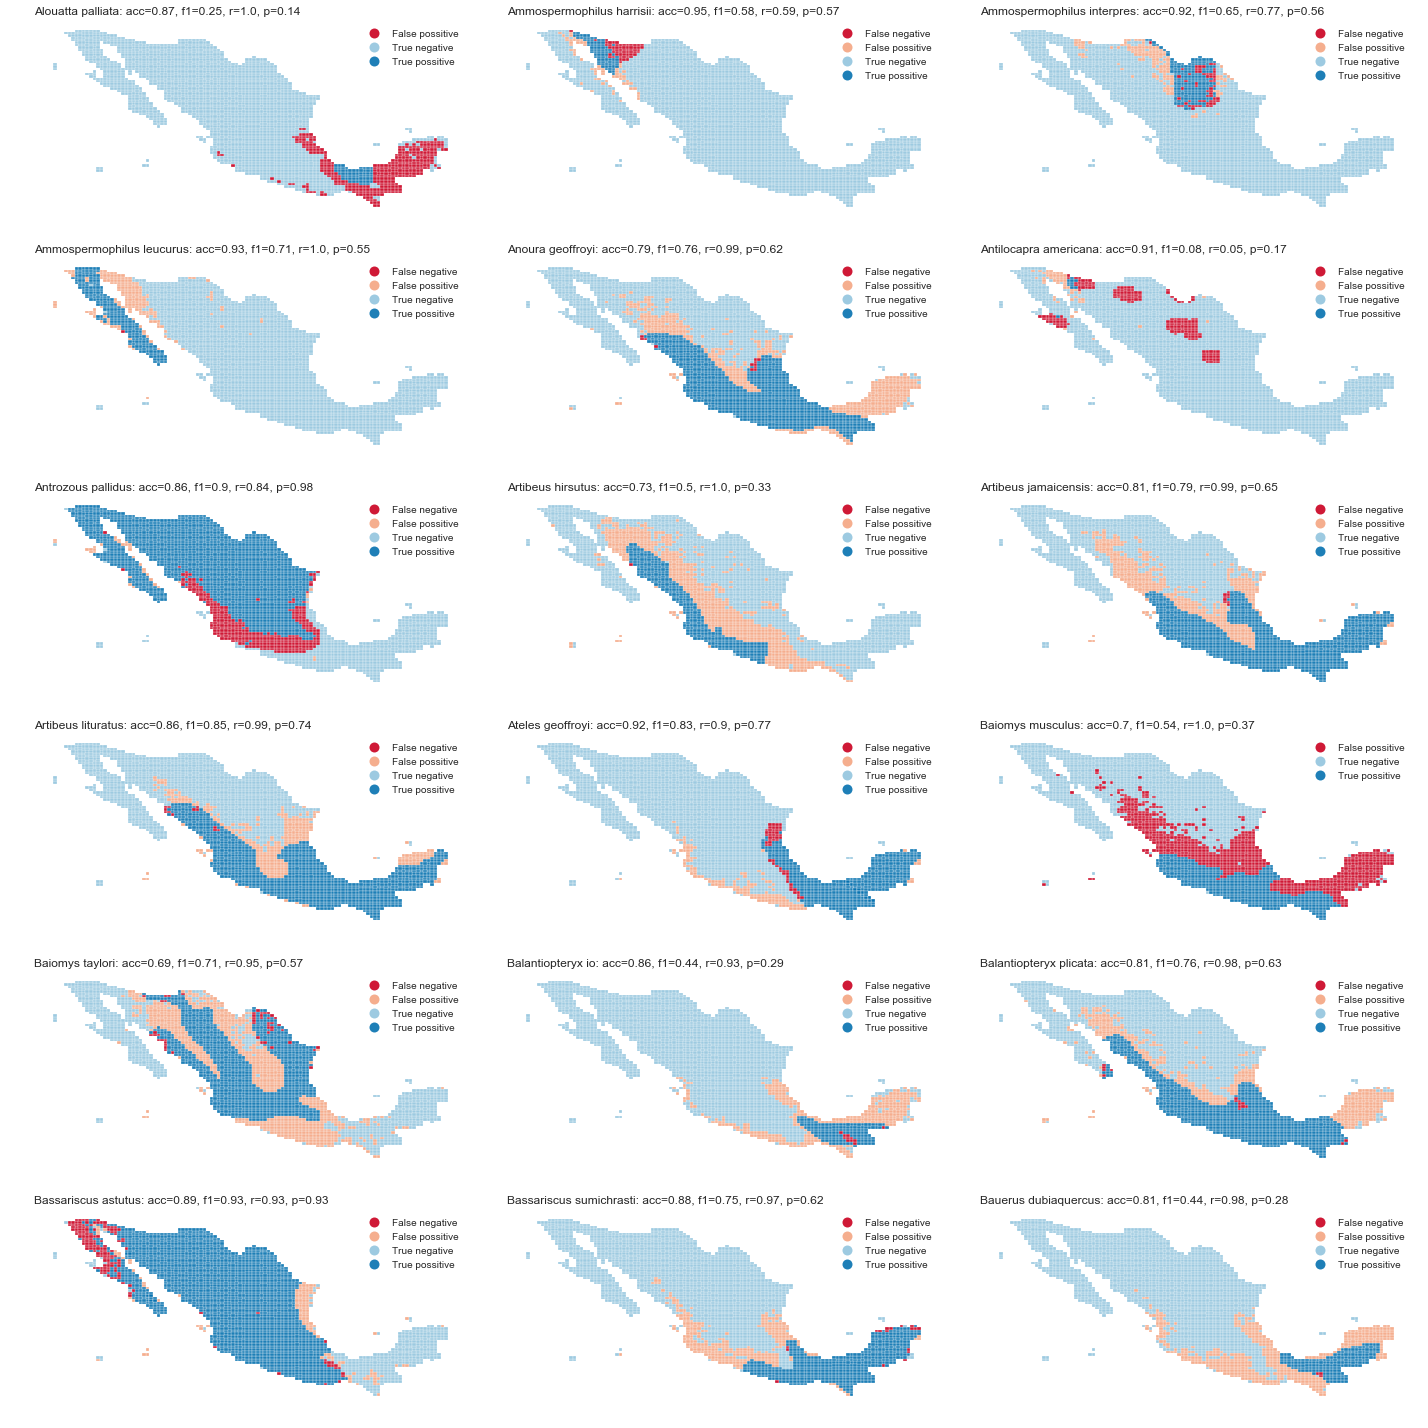

In [172]:
print_eval_stats(sdms32_df)
plot_confussion_maps(sdms32_df, 20)

In [216]:
stats = []
sp_grp = sdms32_df.groupby('species')
for name, grp in sp_grp:
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    
    stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec, 'name': name})

In [217]:
df = pd.DataFrame(stats)
df.describe()

,acc,f1,precision,recall
count,438.000000,438.000000,438.000000,438.000000
mean,0.866085,0.508592,0.457562,0.817571
std,0.109656,0.269365,0.286110,0.250667
min,0.223768,0.000000,0.000000,0.000000
25%,0.812145,0.283875,0.196104,0.750000
50%,0.884805,0.556395,0.477727,0.928811
75%,0.952539,0.727401,0.678001,0.990049
max,1.000000,1.000000,1.000000,1.000000


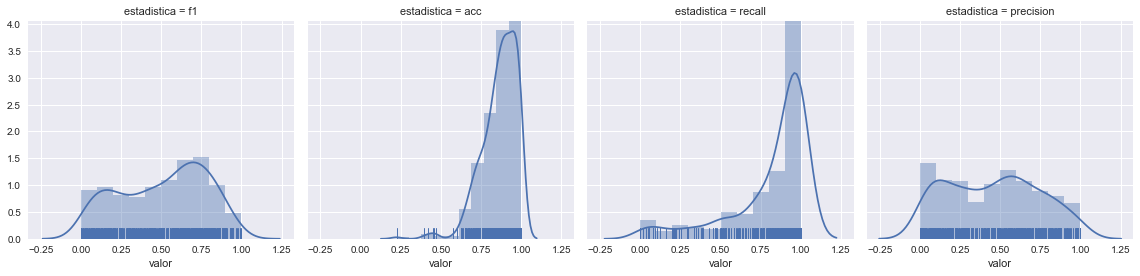

In [218]:
df_test = pd.melt(df[['f1', 'acc', 'recall', 'precision']], var_name=['estadistica'], value_name='valor')

g = sns.FacetGrid(df_test, col='estadistica', size=4)
g.map(sns.distplot, 'valor', bins=10, kde=True, rug=True)

### 16 km

In [ ]:
%time sdms16_df = full_analysis(analysis_res=64, truth_shape=iucn_shp, bioclim_groups=bioclim_groups, biotic_groups=biotic_groups)

Accuracy:  0.871802247704206
F1 score:  0.6799336413695404
Recall:  0.8182930240905348
Precision:  0.5815957307122358

 clasification report: 
              precision    recall  f1-score   support

          0       0.96      0.88      0.92   3796172
          1       0.58      0.82      0.68    757808

avg / total       0.90      0.87      0.88   4553980


 confussion matrix: 
 [[3350061  446111]
 [ 137699  620109]]


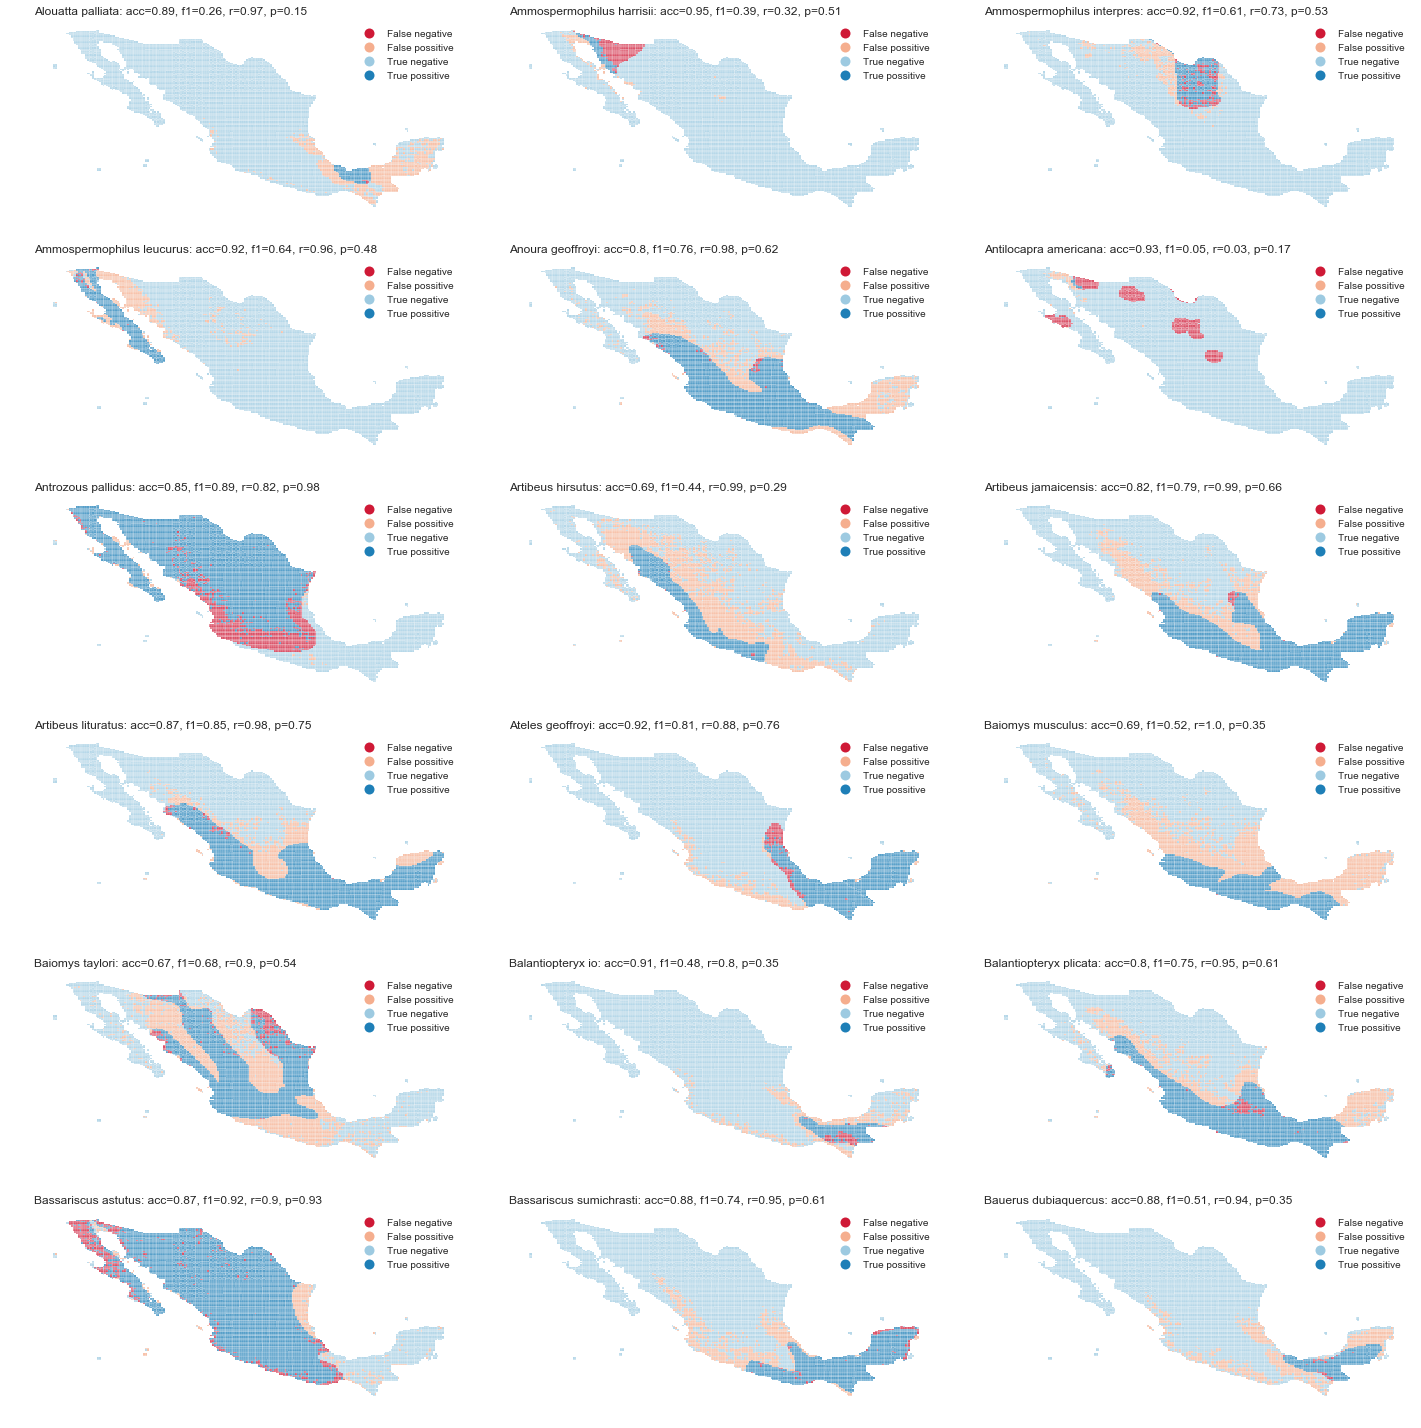

In [244]:
print_eval_stats(sdms16_df)
plot_confussion_maps(sdms16_df, 20)

In [245]:
stats = []
sp_grp = sdms16_df.groupby('species')
for name, grp in sp_grp:
    acc = accuracy_score(grp.presence, grp.pred)
    f1 = f1_score(grp.presence, grp.pred)
    recall = recall_score(grp.presence, grp.pred)
    prec = precision_score(grp.presence, grp.pred)
    
    stats.append({'acc': acc, 'f1': f1, 'recall': recall, 'precision': prec, 'name': name})

In [246]:
df = pd.DataFrame(stats)
df.describe()

,acc,f1,precision,recall
count,438.000000,438.000000,438.000000,438.000000
mean,0.871779,0.481156,0.449283,0.750425
std,0.110671,0.275752,0.291587,0.282879
min,0.192454,0.000000,0.000000,0.000000
25%,0.812531,0.246146,0.189561,0.640054
50%,0.895564,0.501174,0.458474,0.867064
75%,0.958923,0.712231,0.687392,0.962022
max,1.000000,1.000000,1.000000,1.000000


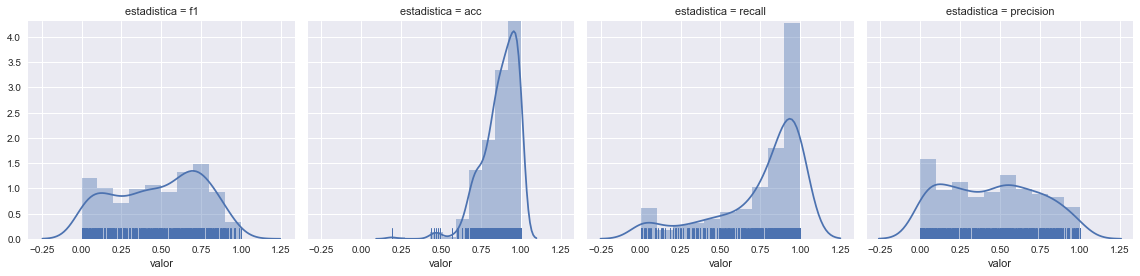

In [247]:
df_test = pd.melt(df[['f1', 'acc', 'recall', 'precision']], var_name=['estadistica'], value_name='valor')

g = sns.FacetGrid(df_test, col='estadistica', size=4)
g.map(sns.distplot, 'valor', bins=10, kde=True, rug=True)

## Modelo con variables climáticas (WorldClim 1.4)

In [43]:
bioclim_groups = {'root_bioclim': 'Bioclim'}

### 64 km

In [ ]:
%time sdms64_abio_df = full_analysis(analysis_res=64, truth_shape=iucn_shp, bioclim_groups=bioclim_groups)

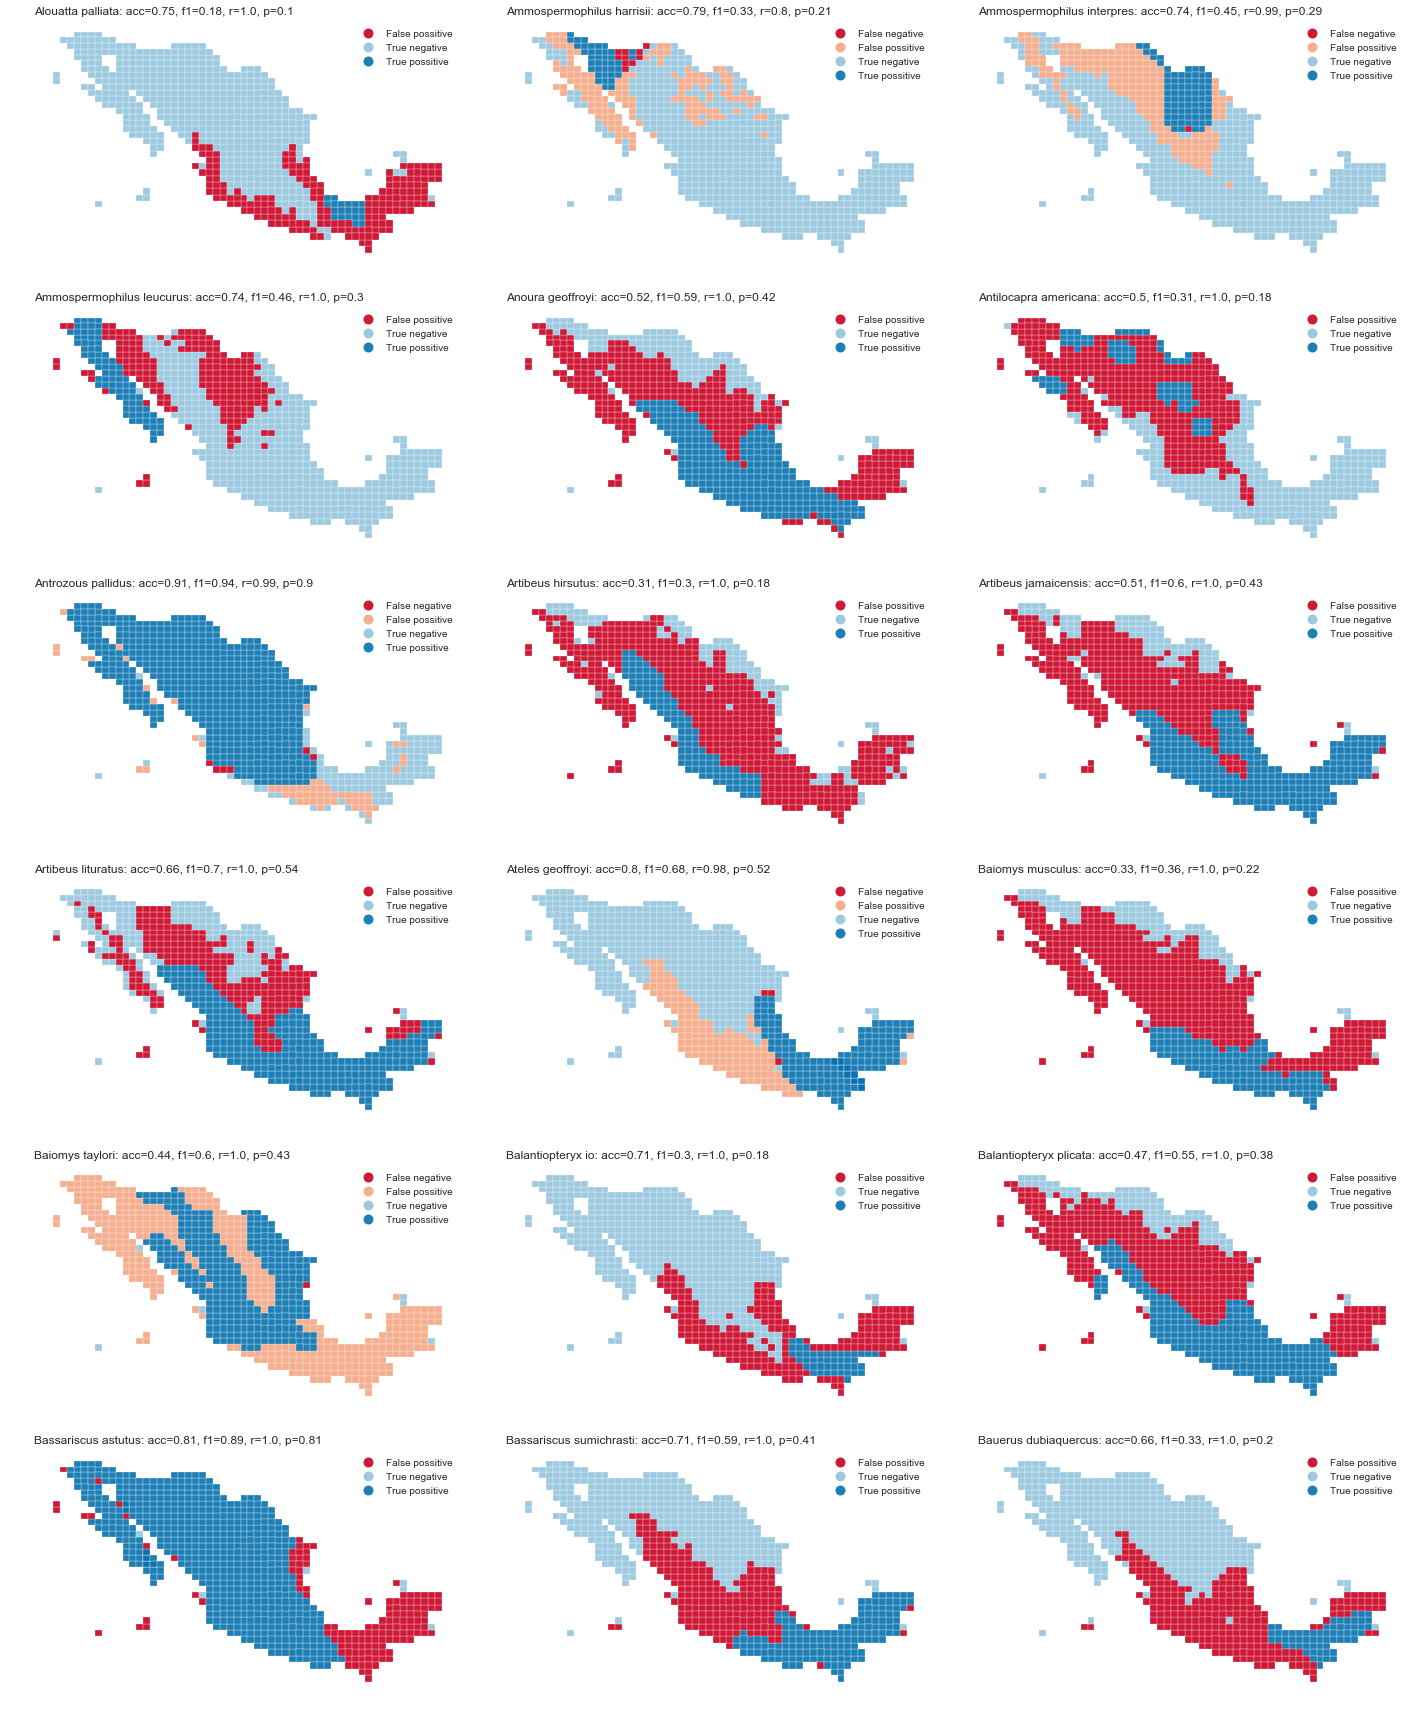

In [80]:
plot_confussion_maps(sdms64_abio_df, 20)

Accuracy:  0.6602903075899732
F1 score:  0.5055153966885514
Recall:  0.9827076457645765
Precision:  0.3402793897945943

 clasification report: 
              precision    recall  f1-score   support

          0       0.99      0.59      0.74    271061
          1       0.34      0.98      0.51     58176

avg / total       0.88      0.66      0.70    329237



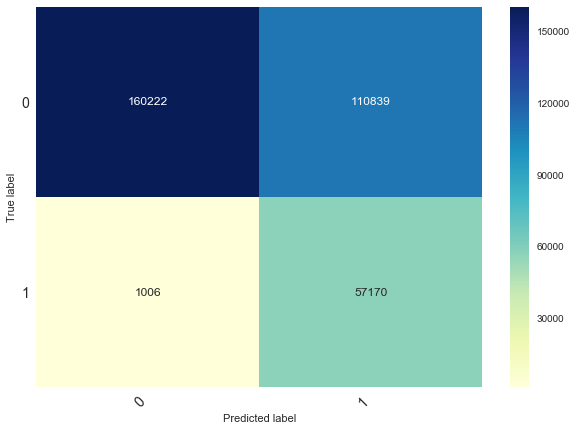

In [78]:
print_eval_stats(sdms64_abio_df)

In [ ]:
stats = get_stats_per_species(sdms64_abio_df)

### 32 Km

In [94]:
%time sdms32_abio_df = full_analysis(analysis_res=32, truth_shape=iucn_shp, bioclim_groups=bioclim_groups, verbose=True)

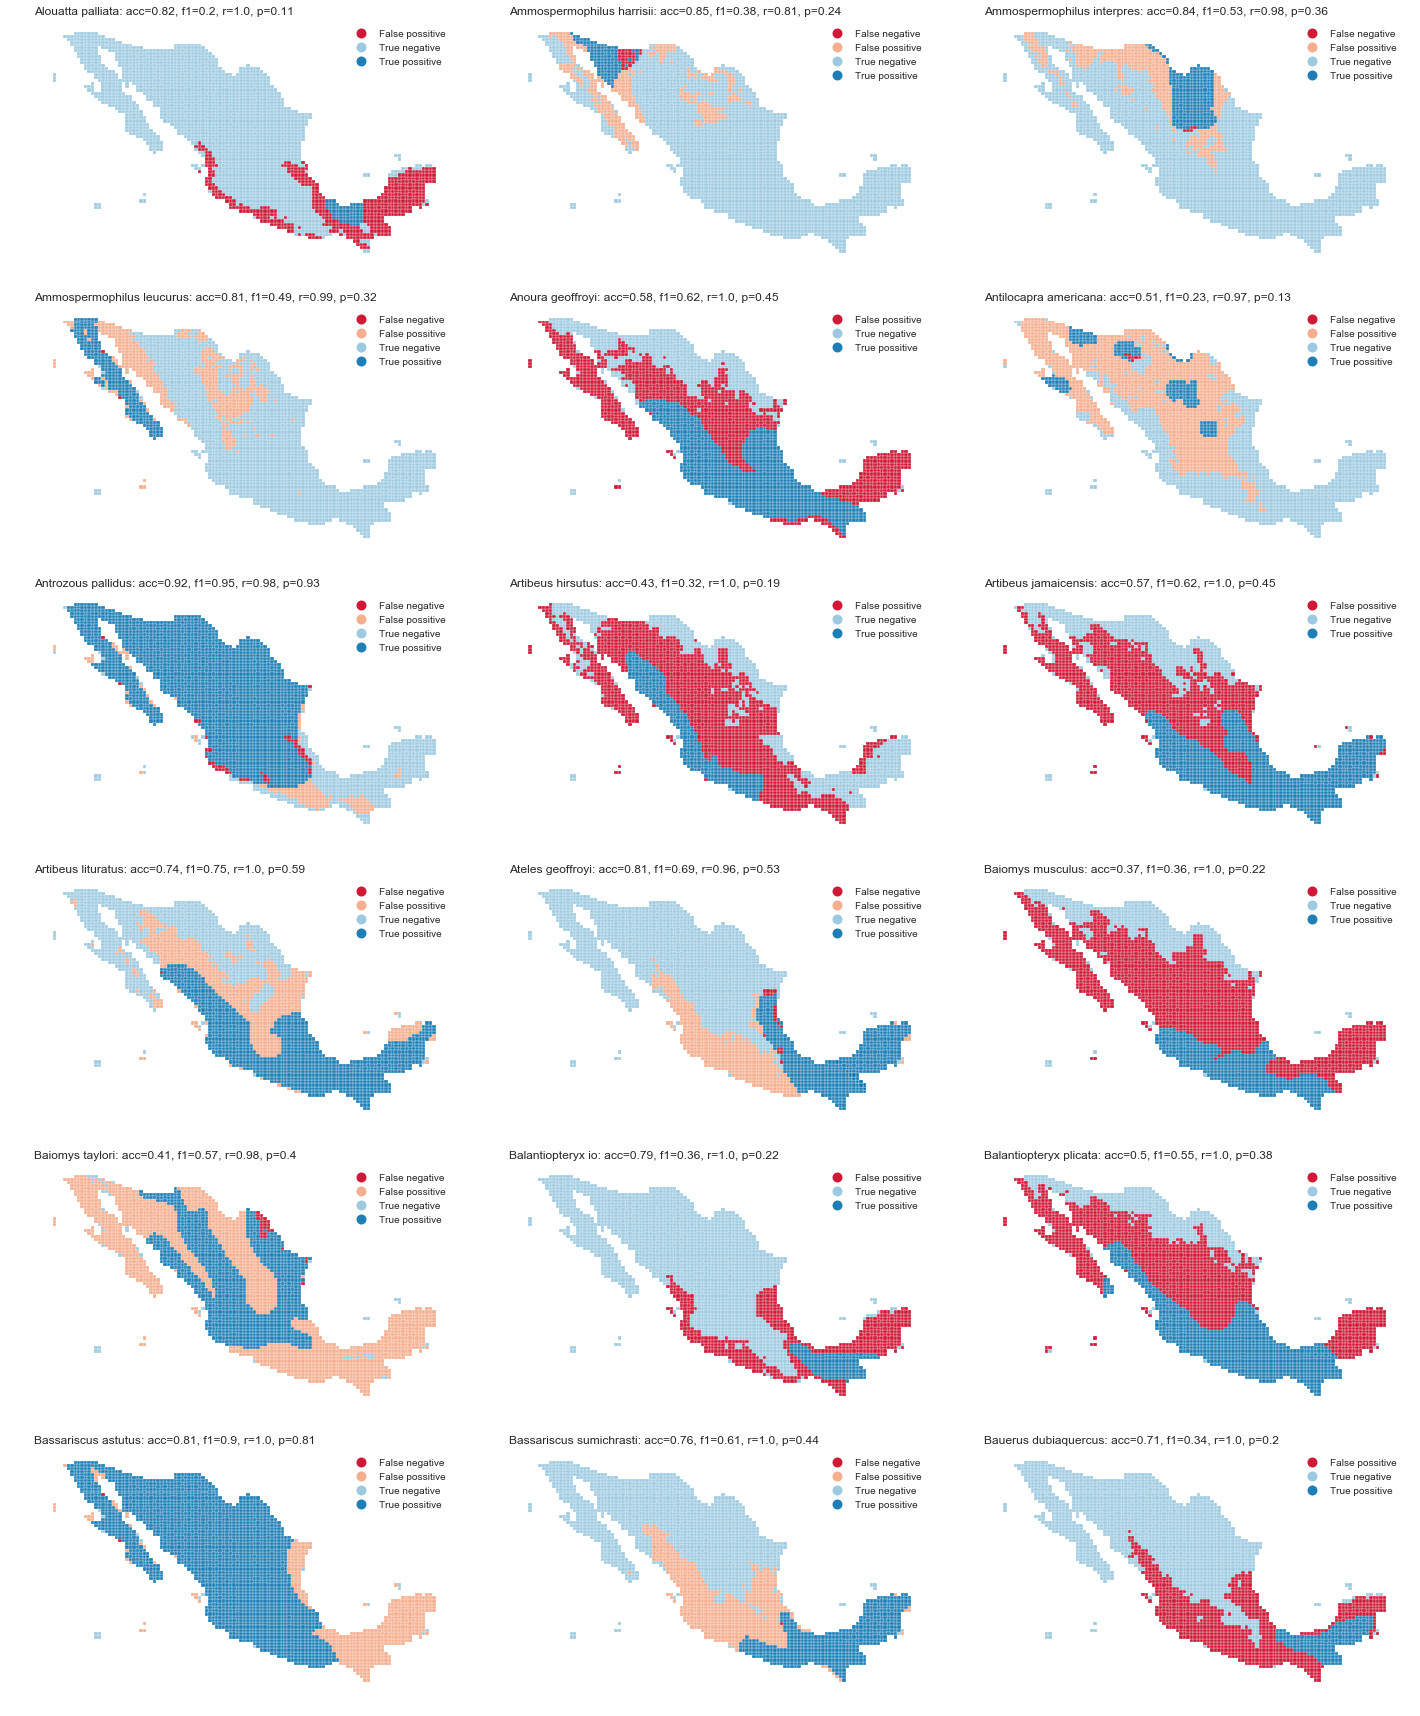

In [143]:
plot_confussion_maps(sdms32_abio_df, 20)

In [95]:
stats = get_stats_per_species(sdms32_abio_df)

In [99]:
df = pd.DataFrame(stats)

In [119]:
lowest_f1 = df[df.f1 <= df.quantile([.02, .45, .55, .95]).f1.iloc[0]]

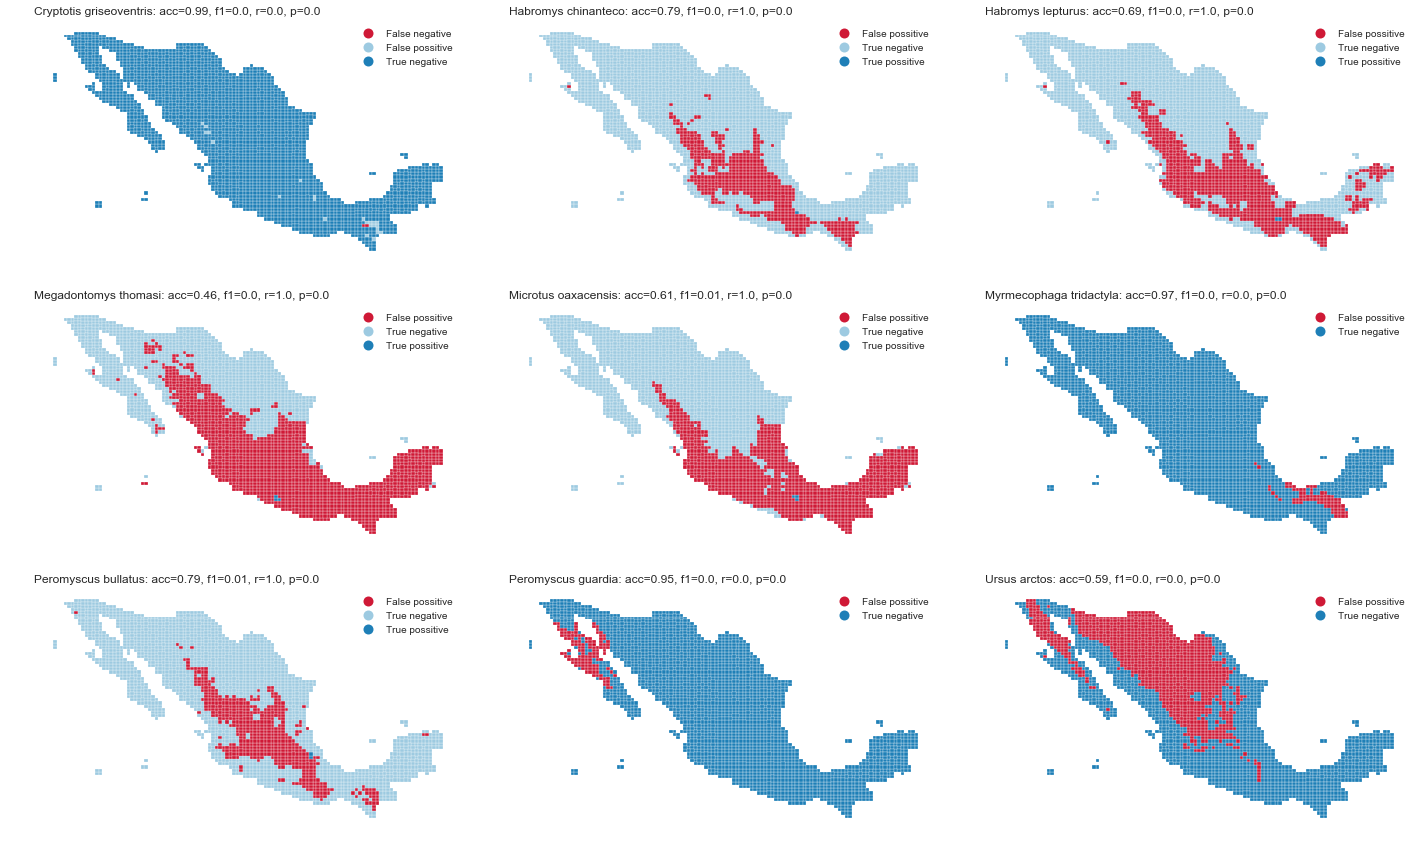

In [125]:
plot_confussion_maps(sdms32_abio_df[sdms32_abio_df.species.isin(lowest_f1.name)], 9)

In [ ]:
plot_confussion_maps(sdms32_abio_df[sdms32_abio_df.species.isin(lowest_f1.name)], 9)

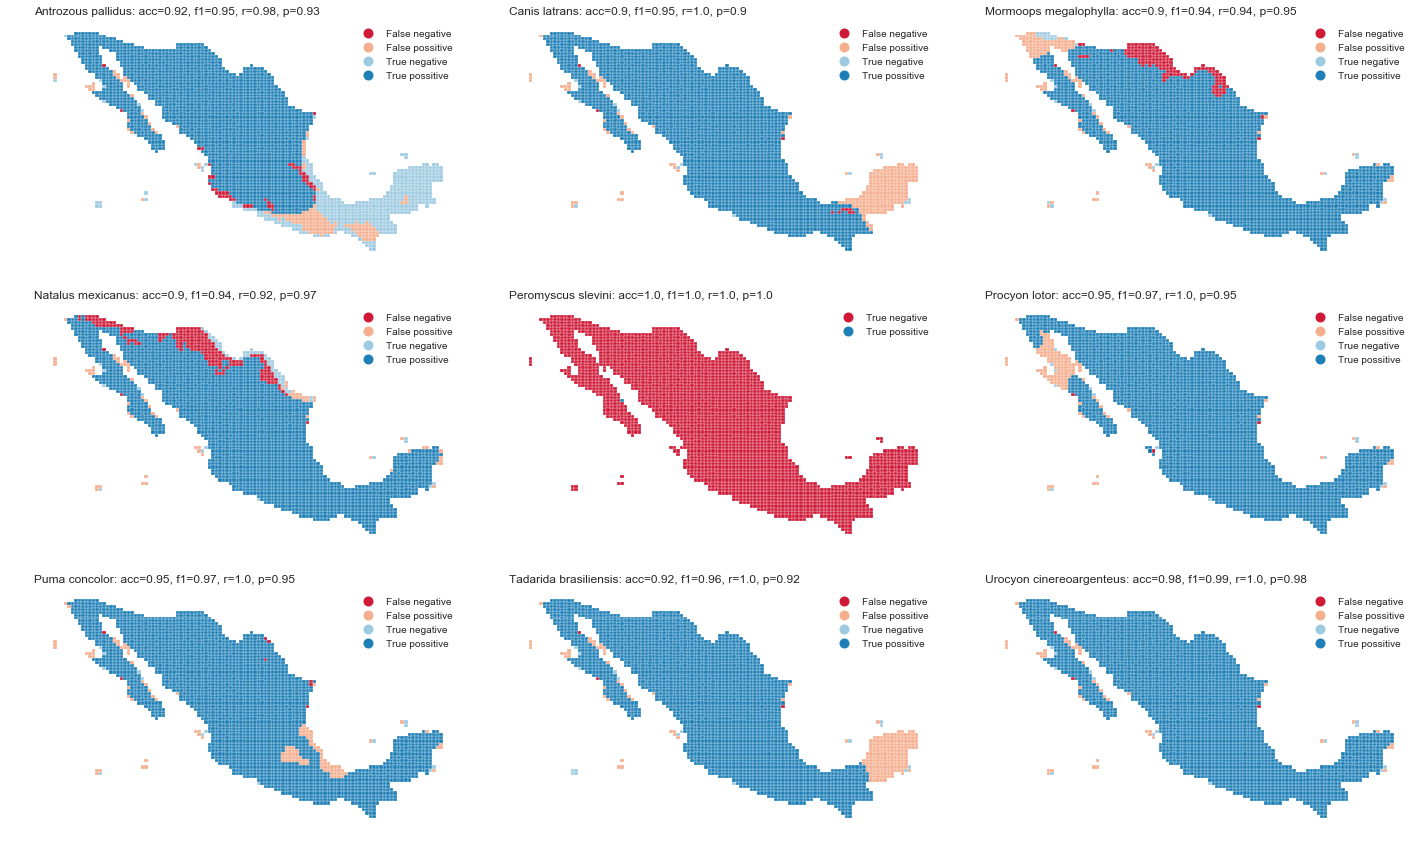

In [138]:
highest_f1 = df[df.f1 >= df.quantile([.02, .45, .55, .98]).f1.iloc[3]]
plot_confussion_maps(sdms32_abio_df[sdms32_abio_df.species.isin(highest_f1.name)], 9)

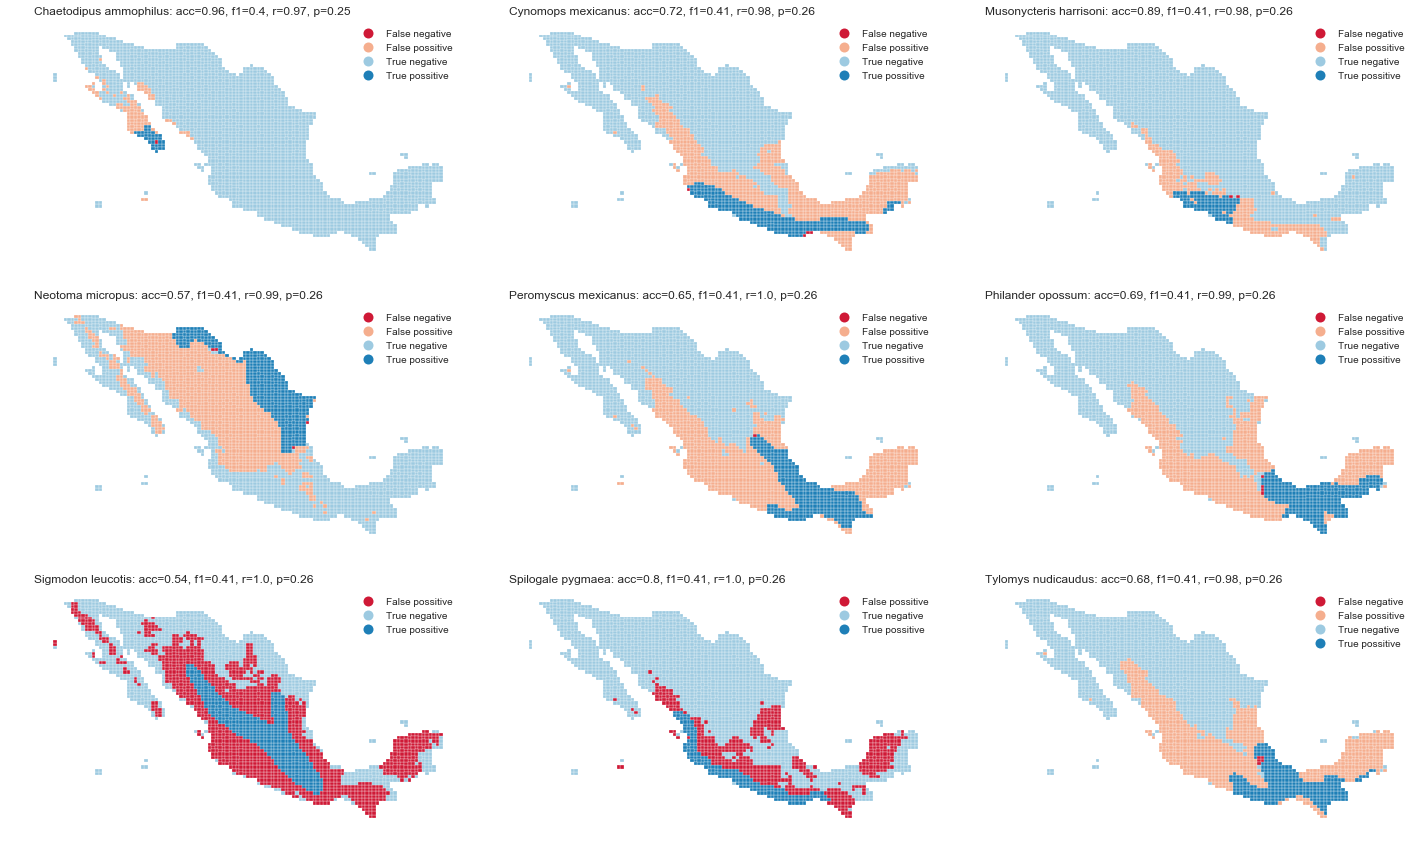

In [141]:
midd_f1 = df[(df.f1.between(df.quantile([.50, .52]).f1.iloc[0], df.quantile([.50, .52]).f1.iloc[1]))]
plot_confussion_maps(sdms32_df[sdms32_df.species.isin(midd_f1.name)], 9)

### 16 km

In [ ]:
%time sdms16_abio_df = full_analysis(analysis_res=16, truth_shape=iucn_shp, bioclim_groups=bioclim_groups)

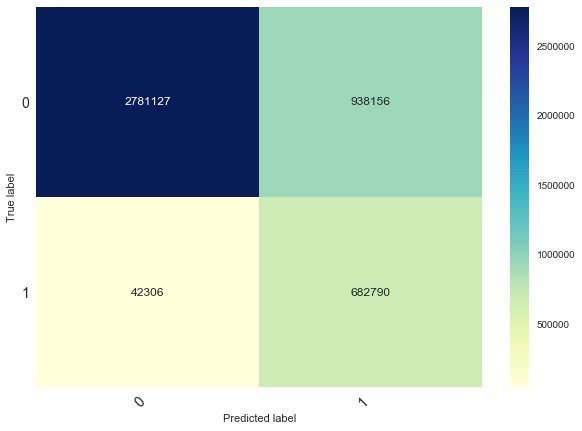

Accuracy:  0.7793928015590029
F1 score:  0.582078240713508
Recall:  0.9416546222844975
Precision:  0.4212293315138197

 clasification report: 
              precision    recall  f1-score   support

          0       0.99      0.75      0.85   3719283
          1       0.42      0.94      0.58    725096

avg / total       0.89      0.78      0.81   4444379



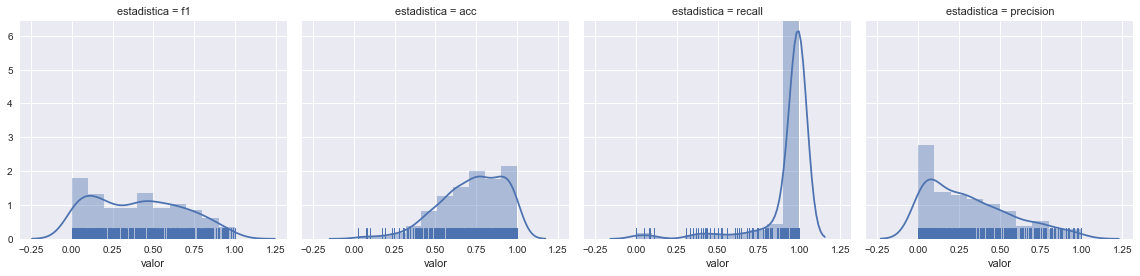

In [178]:
print_eval_stats(sdms16_abio_df)

## Analisis con todos los animales y todas las plantas

In [219]:
bioclim_groups = {'Bioclim': 'root_bioclim'}
biotic_groups = {'Animalia': 'reinovalido', 'Plantae': 'reinovalido'}

In [ ]:
%time sdms64_reinos_df = full_analysis(analysis_res=64, truth_shape=iucn_shp, bioclim_groups=bioclim_groups, biotic_groups=biotic_groups, n=10)

In [ ]:
print_eval_stats(sdms32_reinos_df)

Los siguientes mapas muestran los peores modelos (mapas 1 a 6), modelos intermedios (mapas 7 a 12), y los mejores modelos (mapas 13 a 18), con respecto al score f1.

$$ f1 = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} $$

In [ ]:
plot_bottom_mid_top_maps(sdms32_reinos_df, 0.1)